In [48]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from pyrsgis import raster
from pyrsgis import ml
import random
from copy import copy
from itertools import cycle
from osgeo import gdal
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
from scipy import interp
from sklearn.preprocessing import label_binarize

In [2]:
featurefile = r'E:/Sentinel2/Sistan_Sentinel.tif'

In [3]:
lablefile = r'E:/Sentinel2/Sistan_Sentinel_Training.tif'

In [4]:
dsfeature , arrayfeature = raster.read(featurefile, bands = 'all')
arrayfeature = arrayfeature.astype(float)

In [5]:
print(arrayfeature)

[[[2112. 2070. 2056. ... 2527. 2510. 2522.]
  [2117. 2102. 2065. ... 2532. 2585. 2622.]
  [2125. 2125. 2116. ... 2545. 2543. 2592.]
  ...
  [1397. 1411. 1417. ... 2112. 2095. 2083.]
  [1454. 1442. 1470. ... 2085. 2096. 2086.]
  [1574. 1491. 1475. ... 2088. 2097. 2104.]]

 [[2308. 2288. 2270. ... 2888. 2868. 2850.]
  [2345. 2294. 2290. ... 2887. 2938. 2968.]
  [2352. 2349. 2333. ... 2915. 2913. 2962.]
  ...
  [1381. 1387. 1412. ... 2364. 2349. 2335.]
  [1437. 1456. 1471. ... 2357. 2343. 2342.]
  [1582. 1499. 1500. ... 2351. 2356. 2338.]]

 [[2745. 2711. 2721. ... 3568. 3536. 3547.]
  [2752. 2719. 2746. ... 3549. 3563. 3636.]
  [2796. 2756. 2762. ... 3549. 3587. 3665.]
  ...
  [1482. 1521. 1555. ... 2882. 2837. 2836.]
  [1582. 1607. 1599. ... 2869. 2869. 2847.]
  [1805. 1649. 1637. ... 2858. 2853. 2830.]]

 ...

 [[3002. 3002. 2976. ... 3866. 3931. 3931.]
  [3002. 3002. 2976. ... 3866. 3931. 3931.]
  [2941. 2941. 2920. ... 3919. 3909. 3909.]
  ...
  [1723. 1723. 1680. ... 3024. 3012. 301

In [6]:
arrayfeature.shape

(10, 866, 770)

In [7]:
for i in range(arrayfeature.shape[0]):
 minb = arrayfeature [i][:][:].min()
 maxb = arrayfeature [i][:][:].max()
 rangeb = maxb - minb
 for j in range(arrayfeature.shape[1]):
    for k in range(arrayfeature.shape[2]):
        arrayfeature[i][j][k] = (arrayfeature[i][j][k] - minb)/rangeb

In [8]:
print(arrayfeature)

[[[0.46893975 0.44932275 0.44278375 ... 0.6627744  0.65483419 0.66043905]
  [0.47127511 0.46426903 0.44698739 ... 0.66510976 0.68986455 0.70714619]
  [0.47501168 0.47501168 0.47080803 ... 0.67118169 0.67024755 0.69313405]
  ...
  [0.13498365 0.14152265 0.14432508 ... 0.46893975 0.46099953 0.45539468]
  [0.16160673 0.15600187 0.16907987 ... 0.45632882 0.4614666  0.45679589]
  [0.2176553  0.17888837 0.17141523 ... 0.45773003 0.46193368 0.46520318]]

 [[0.48655617 0.47918969 0.47255985 ... 0.70018416 0.69281768 0.68618785]
  [0.50018416 0.48139963 0.47992634 ... 0.69981584 0.71860037 0.72965009]
  [0.50276243 0.50165746 0.49576427 ... 0.71012891 0.70939227 0.72744015]
  ...
  [0.14511971 0.14732965 0.15653775 ... 0.50718232 0.50165746 0.49650092]
  [0.16574586 0.17274401 0.17826888 ... 0.50460405 0.49944751 0.49907919]
  [0.21915285 0.18858195 0.18895028 ... 0.50239411 0.50423573 0.49760589]]

 [[0.49627721 0.48654066 0.48940435 ... 0.73195876 0.72279496 0.72594502]
  [0.49828179 0.488831

In [9]:
print (arrayfeature.shape)

(10, 866, 770)


In [10]:
features = ml.array_to_chips(arrayfeature, y_size=7, x_size=7)

In [11]:
features.shape

(666820, 7, 7, 10)

In [12]:
dslable, arraylable = raster.read(lablefile)

In [13]:
np.unique(arraylable)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 255], dtype=uint8)

In [14]:
arraylable[arraylable==255]=0

In [15]:
np.unique(arraylable)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [16]:
arraylable = arraylable.flatten()

In [17]:
arraylable.shape

(666820,)

In [18]:
features = features[arraylable != 0]
lable = arraylable[arraylable != 0]

In [19]:
np.unique(lable)

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [20]:
slin = int(features.shape[0] * 0.70)

In [21]:
slin

27069

In [22]:
def train_test_split(features, lable, trainprob = 0.70):
    datasize = features.shape[0]
    sliceindex = int(datasize * trainprob)
    randindex = np.arange(datasize)
    random.shuffle(randindex)
    train_x = features[[randindex[:sliceindex]],:,:,:][0]
    test_x = features[[randindex[sliceindex:]],:,:,:][0]
    train_y = lable[randindex[:sliceindex]]
    test_y = lable[randindex[sliceindex:]]
    return(train_x, train_y, test_x, test_y)

In [23]:
train_x, train_y, test_x, test_y = train_test_split(features, lable)

In [24]:
print(train_x)
print(train_y)
print(test_x)
print(test_y)

[[[[0.42643624 0.46445672 0.4742268  ... 0.4478364  0.54535199
    0.5476766 ]
   [0.43344232 0.46298343 0.47623139 ... 0.45672792 0.54625451
    0.54982541]
   [0.42970574 0.46924494 0.47479954 ... 0.45672792 0.54625451
    0.54982541]
   ...
   [0.47034096 0.50497238 0.50114548 ... 0.45909899 0.55054152
    0.55036261]
   [0.46847268 0.50791897 0.50114548 ... 0.4570243  0.56114621
    0.55412302]
   [0.4680056  0.50055249 0.50400916 ... 0.4570243  0.56114621
    0.55412302]]

  [[0.43951425 0.47071823 0.47107675 ... 0.4478364  0.54535199
    0.5476766 ]
   [0.46053246 0.47145488 0.49198167 ... 0.45672792 0.54625451
    0.54982541]
   [0.46099953 0.48434622 0.50315006 ... 0.45672792 0.54625451
    0.54982541]
   ...
   [0.46613732 0.49834254 0.49799542 ... 0.45909899 0.55054152
    0.55036261]
   [0.46893975 0.50276243 0.49770905 ... 0.4570243  0.56114621
    0.55412302]
   [0.47080803 0.50313076 0.50572738 ... 0.4570243  0.56114621
    0.55412302]]

  [[0.45913125 0.48581952 0.497422

In [25]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(27069, 7, 7, 10)
(27069,)
(11602, 7, 7, 10)
(11602,)


In [26]:
model =  tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size = 1, padding = 'valid', activation = 'relu',
                                 input_shape = (train_x.shape[1], train_x.shape[2], train_x.shape[3])))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(48, kernel_size = 1, padding = 'valid', activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 32)          352       
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 48)          1584      
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 48)          0         
                                                                 
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 64)                150592    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [27]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.fit(train_x, train_y, epochs =20)

Epoch 1/20
846/846 [==============================] - 9s 7ms/step - loss: 0.7592 - accuracy: 0.7561
Epoch 2/20
846/846 [==============================] - 5s 6ms/step - loss: 0.3872 - accuracy: 0.8678
Epoch 3/20
846/846 [==============================] - 5s 6ms/step - loss: 0.2992 - accuracy: 0.8941
Epoch 4/20
846/846 [==============================] - 5s 6ms/step - loss: 0.2567 - accuracy: 0.9101
Epoch 5/20
846/846 [==============================] - 5s 6ms/step - loss: 0.2336 - accuracy: 0.9203
Epoch 6/20
846/846 [==============================] - 5s 6ms/step - loss: 0.2105 - accuracy: 0.9274
Epoch 7/20
846/846 [==============================] - 5s 6ms/step - loss: 0.1899 - accuracy: 0.9361
Epoch 8/20
846/846 [==============================] - 5s 6ms/step - loss: 0.1831 - accuracy: 0.9382
Epoch 9/20
846/846 [==============================] - 5s 6ms/step - loss: 0.1702 - accuracy: 0.9436
Epoch 10/20
846/846 [==============================] - 5s 6ms/step - loss: 0.1620 - accuracy: 0.9459

In [28]:
dspre , featurepre = raster.read(r'E:/Sentinel2/Sistan_Sentinel.tif')
featurepre = featurepre.astype(float)

In [29]:
for i in range(featurepre.shape[0]):
 minb = featurepre [i][:][:].min()
 maxb = featurepre [i][:][:].max()
 rangeb = maxb - minb
 for j in range(featurepre.shape[1]):
    for k in range(featurepre.shape[2]):
        featurepre[i][j][k] = (featurepre[i][j][k] - minb)/rangeb

In [30]:
new_features = ml.array_to_chips(featurepre, x_size = 7, y_size = 7)

In [31]:
newpredicted = model.predict(new_features)

20839/20839 [==============================] - 59s 2ms/step


In [32]:
prediction = np.reshape(newpredicted.argmax(axis = 1), (dspre.RasterYSize, dspre.RasterXSize))

In [33]:
prediction.shape

(866, 770)

In [34]:
outfile = r'E:/Sentinel2/CNN.tif'
raster. export(prediction, dspre, filename = outfile, dtype = 'float')

In [35]:
cnn_map = prediction
print(cnn_map.shape)

(866, 770)


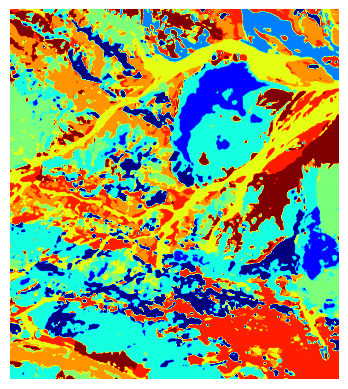

In [36]:
plt.figure()
plt.imshow(cnn_map, cmap = 'jet')
plt.axis('off')
plt.show()

In [37]:
yTestPredicted = model.predict(test_x)

363/363 [==============================] - 1s 3ms/step


In [38]:
y_score = yTestPredicted[:, 1:yTestPredicted.shape[1]]

In [39]:
yTestPredicted

array([[3.1596161e-09, 6.5774857e-09, 3.6813507e-11, ..., 9.9999964e-01,
        1.5973226e-10, 7.6016908e-09],
       [5.9092009e-18, 1.2353915e-22, 5.4838751e-09, ..., 6.1921865e-22,
        1.2519170e-34, 6.6279960e-18],
       [1.6550116e-08, 3.5507230e-09, 4.4731747e-17, ..., 2.1155557e-07,
        1.3225214e-04, 3.8446203e-08],
       ...,
       [6.8025168e-09, 1.2145422e-13, 6.2521514e-15, ..., 1.9268136e-09,
        5.9713904e-07, 9.9998653e-01],
       [2.2593671e-18, 5.9600891e-19, 9.9999988e-01, ..., 2.1015997e-22,
        4.3644461e-38, 1.6635828e-27],
       [4.1540918e-08, 2.2376884e-08, 6.6263646e-01, ..., 6.2103553e-08,
        2.8096444e-17, 3.6042818e-11]], dtype=float32)

In [40]:
yTestPredicted = (yTestPredicted > 0.5).astype(int)

In [41]:
cMatrix =  confusion_matrix(test_y, yTestPredicted.argmax(axis=1))
pScore = precision_score(test_y, yTestPredicted.argmax(axis=1), average = 'micro')
rScore = recall_score(test_y, yTestPredicted.argmax(axis=1), average = 'micro')
fScore = f1_score(test_y, yTestPredicted.argmax(axis=1), average = 'micro')

In [42]:
print("Confusion Matrix:\n", cMatrix)

Confusion Matrix:
 [[   0    0    0    0    0    0    0    0    0    0]
 [   0  733    0    0    0    1    0    0    2    0]
 [   0    0 1517    0    2    0    0    0    0    0]
 [   1    0    0  251    0    0    0    0    2    1]
 [  12    4   23    0 3297    8    0    1    0   23]
 [  11    0    9    0    5 3214   89    0    0    0]
 [   3    0    0    9    0    0 1176    3    4    0]
 [   1    0    0    0    0    0    0  714    5    1]
 [   0    0    0    0    0    0    0    0  166    0]
 [   0    0    0    0    0    0    0    0    0  314]]


In [43]:
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fScore))


P-Score: 0.981, R-Score: 0.981, F-Score: 0.981


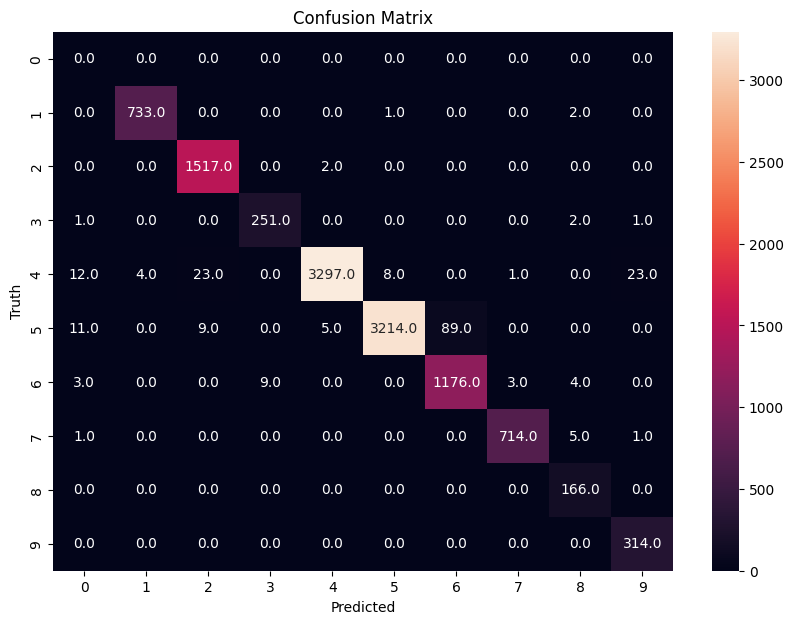

In [44]:
plt.figure(figsize=(10,7))
sns.heatmap(cMatrix, annot = True, fmt = ".1f")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

In [46]:
n_classes = 9
fpr = dict()
tpr = dict()
roc_auc = dict()

In [47]:
np.unique(lable)

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [50]:
test_y = label_binarize(test_y, classes = list(range(1, n_classes+1)))

In [51]:
test_y

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [52]:
np.unique(test_y)

array([0, 1])

In [53]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [54]:
fpr

{0: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.20301859e-05, 9.20301859e-05, 1.84060372e-04, 1.84060372e-04,
        7.36241487e-04, 7.36241487e-04, 1.38045279e-03, 1.38045279e-03,
        1.56451316e-03, 1.56451316e-03, 9.92821645e-01, 1.00000000e+00]),
 1: array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        9.91768323e-05, 9.91768323e-05, 1.98353665e-04, 1.98353665e-04,
        3.96707329e-04, 3.96707329e-04, 1.09094516e-03, 

In [55]:
tpr

{0: array([0.        , 0.70380435, 0.7513587 , 0.79755435, 0.8125    ,
        0.82472826, 0.83559783, 0.8423913 , 0.84782609, 0.85054348,
        0.85326087, 0.85597826, 0.86141304, 0.87228261, 0.875     ,
        0.8763587 , 0.87907609, 0.88586957, 0.88994565, 0.99184783,
        0.99184783, 0.99456522, 0.99456522, 0.99592391, 0.99592391,
        0.99728261, 0.99728261, 0.9986413 , 0.9986413 , 1.        ,
        1.        , 1.        ]),
 1: array([0.        , 0.89071758, 0.91441738, 0.91836735, 0.92495063,
        0.92824226, 0.93219223, 0.93350889, 0.93745885, 0.94075049,
        0.94206715, 0.94272548, 0.94535879, 0.94865043, 0.94996708,
        0.95457538, 0.95457538, 0.98485846, 0.98485846, 0.99012508,
        0.99012508, 0.99078341, 0.99078341, 0.99210007, 0.99210007,
        0.99341672, 0.99341672, 0.99473338, 0.99473338, 0.99670836,
        0.99670836, 0.99736669, 0.99736669, 0.99802502, 0.99802502,
        0.99868334, 0.99868334, 0.99934167, 0.99934167, 1.        ,
        

In [58]:
fpr['micro'], tpr['micro'], _ = roc_curve(test_y.ravel(), y_score.ravel())

ravel make nd array flat

In [59]:
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

In [61]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

In [62]:
all_fpr

array([0.00000000e+00, 8.74431619e-05, 8.81290209e-05, 8.85896527e-05,
       9.19033177e-05, 9.20301859e-05, 9.60891708e-05, 9.91768323e-05,
       1.20860527e-04, 1.21447656e-04, 1.74886324e-04, 1.76258042e-04,
       1.77179305e-04, 1.83806635e-04, 1.84060372e-04, 1.92178342e-04,
       1.98353665e-04, 2.41721054e-04, 2.42895312e-04, 2.62329486e-04,
       2.64387063e-04, 2.65768958e-04, 2.88267512e-04, 3.49772648e-04,
       3.62581581e-04, 3.64342968e-04, 3.67613271e-04, 3.96707329e-04,
       4.37215810e-04, 4.42948264e-04, 4.59516589e-04, 4.80445854e-04,
       4.83442108e-04, 4.85790624e-04, 6.04302635e-04, 6.07238280e-04,
       6.43323224e-04, 7.05032167e-04, 7.25163162e-04, 7.28685936e-04,
       7.36241487e-04, 7.68713366e-04, 7.86988458e-04, 8.46023689e-04,
       8.50133592e-04, 8.64802537e-04, 8.81290209e-04, 9.60891708e-04,
       9.66884216e-04, 9.71581248e-04, 1.05698088e-03, 1.08774474e-03,
       1.09094516e-03, 1.09302890e-03, 1.24915922e-03, 1.28929882e-03,
      

In [63]:
mean_tpr = np.zeros_like(all_fpr)

In [65]:
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

In [66]:
mean_tpr

array([7.82869663, 7.84676892, 7.8859846 , 7.94967887, 7.97325723,
       7.97597462, 8.03706249, 8.06734557, 8.30202105, 8.33230609,
       8.37447476, 8.40976888, 8.41613831, 8.49242125, 8.49377994,
       8.49963768, 8.50490431, 8.51812546, 8.55197344, 8.68450356,
       8.6923467 , 8.74330211, 8.76254898, 8.77459717, 8.77760198,
       8.78146183, 8.7828488 , 8.78350712, 8.80157941, 8.80476413,
       8.80892501, 8.81561957, 8.81862438, 8.82189042, 8.8221909 ,
       8.82516002, 8.82654698, 8.83046855, 8.83377384, 8.83407075,
       8.83542944, 8.84045037, 8.85249856, 8.85640481, 8.85937393,
       8.86021075, 8.86413232, 8.86999006, 8.87119198, 8.87148889,
       8.87232571, 8.87262619, 8.87394285, 8.87423976, 8.87507658,
       8.87639324, 8.88031481, 8.88181721, 8.88349085, 8.88484955,
       8.88635195, 8.88664886, 8.89083296, 8.89219166, 8.89279262,
       8.89368336, 8.8945848 , 8.89488171, 8.89655535, 8.89787201,
       8.89846583, 8.89930265, 8.90013947, 8.90074043, 8.90103

In [71]:
mean_tpr /= n_classes
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

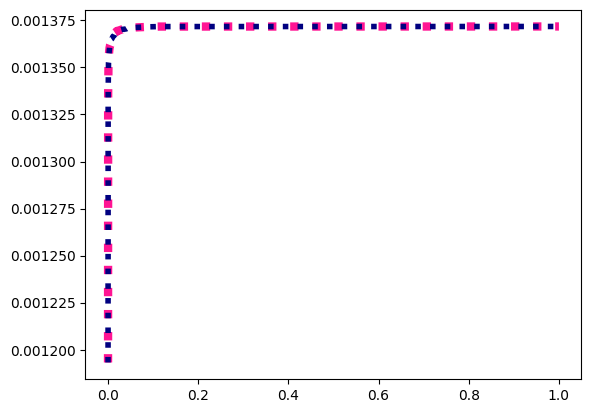

In [88]:
plt.figure(1)
plt.plot(fpr['micro'], tpr['micro'],
        label = 'micro-average ROC curve (area = {0:0.4f})'
         ''.format(roc_auc['micro']),
         color = 'deeppink', linestyle = ':', linewidth = 6)
plt.plot(fpr['macro'], tpr['macro'],
        label = 'Macro-average ROC curve (area = {0:0.4f})'
         ''.format(roc_auc['macro']),
         color = 'navy', linestyle = ':', linewidth = 4)


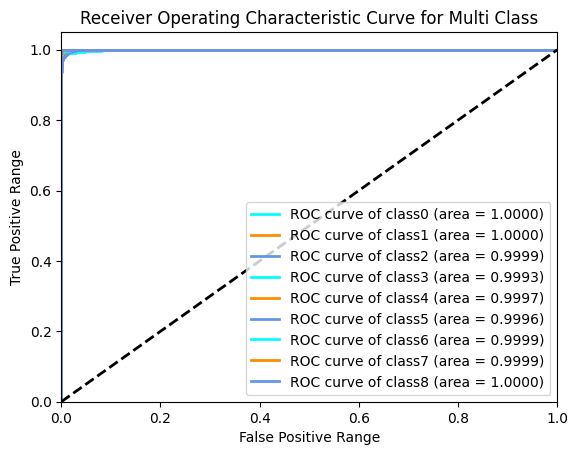

In [89]:
color = cycle(['aqua', 'darkorange','cornflowerblue'])
for i, color in zip (range(n_classes), color):
    plt.plot(fpr[i], tpr[i], color = color, lw = 2,
             label= 'ROC curve of class{0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0,1],[0,1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Range')
plt.ylabel('True Positive Range')
plt.title('Receiver Operating Characteristic Curve for Multi Class')
plt.legend(loc = "lower right")
plt.show()

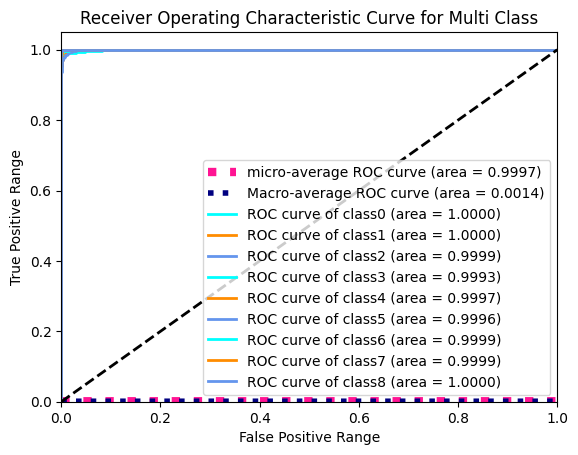

In [91]:
plt.figure(1)
plt.plot(fpr['micro'], tpr['micro'],
        label = 'micro-average ROC curve (area = {0:0.4f})'
         ''.format(roc_auc['micro']),
         color = 'deeppink', linestyle = ':', linewidth = 6)
plt.plot(fpr['macro'], tpr['macro'],
        label = 'Macro-average ROC curve (area = {0:0.4f})'
         ''.format(roc_auc['macro']),
         color = 'navy', linestyle = ':', linewidth = 4)
color = cycle(['aqua', 'darkorange','cornflowerblue'])
for i, color in zip (range(n_classes), color):
    plt.plot(fpr[i], tpr[i], color = color, lw = 2,
             label= 'ROC curve of class{0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))
plt.plot([0,1],[0,1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Range')
plt.ylabel('True Positive Range')
plt.title('Receiver Operating Characteristic Curve for Multi Class')
plt.legend(loc = "lower right")
plt.show()